# Introduction

This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

- [Keras Documentation](https://keras.io/examples/vision/image_classification_from_scratch/)


# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the data: the Cat vs Penguim dataset

In [2]:
!ls /kaggle/input/

animal-picture-set-cat-penguin


In [3]:
!ls /kaggle/input/animal-picture-set-cat-penguin/animals_small_cat_penguin/animals_small_cat_penguin

cats  penguins


In [4]:
!ls /kaggle/input/animal-picture-set-cat-penguin/animals_small_cat_penguin/animals_small_cat_penguin/cat -1 | wc -l

ls: cannot access '/kaggle/input/animal-picture-set-cat-penguin/animals_small_cat_penguin/animals_small_cat_penguin/cat': No such file or directory
0


In [5]:
!ls /kaggle/input/animal-picture-set-cat-penguin/animals_small_cat_penguin/animals_small_cat_penguin/penguim -1 | wc -l

ls: cannot access '/kaggle/input/animal-picture-set-cat-penguin/animals_small_cat_penguin/animals_small_cat_penguin/penguim': No such file or directory
0


# Generate a Dataset

In [6]:
image_size = (180, 180)
batch_size = 24

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/animal-picture-set-cat-penguin/animals_medium_cat_penguin/animals_medium_cat_penguin",
    validation_split=0.15,
    subset="both",
    seed=123456,
    image_size=image_size,
    batch_size=batch_size,
)

Found 804 files belonging to 4 classes.
Using 684 files for training.
Using 120 files for validation.


# Visualize the data

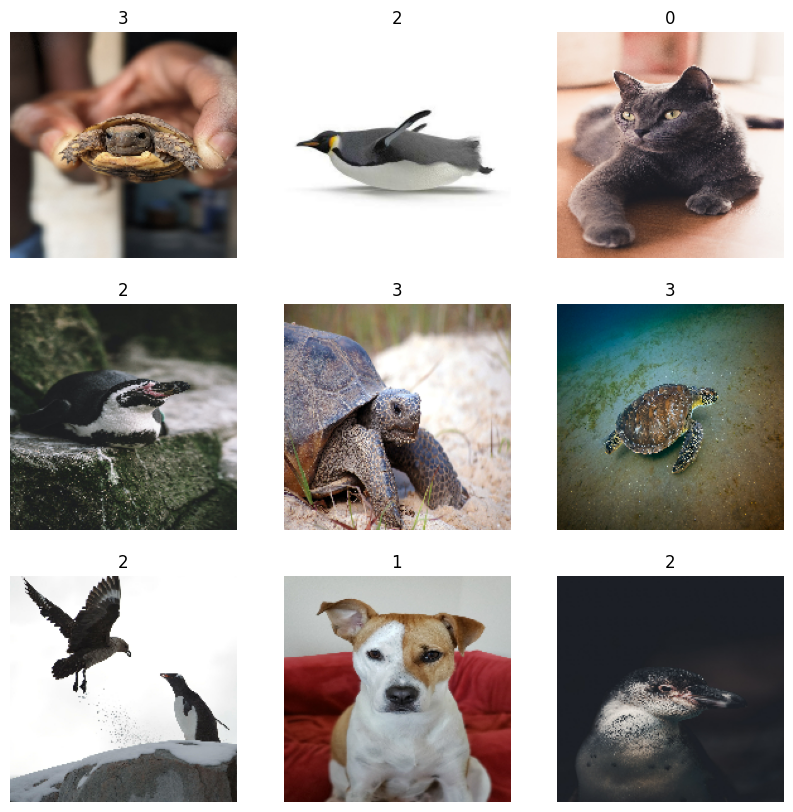

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentation

In [8]:
AUG = {
    # AUGMENTATION
    'AUGMENTATION_RANDOM_FLIP': 'horizontal',
    'AUGMENTATION_RANDOM_ROTATION':0.5,
    'AUGMENTATION_RANDOM_ZOOM':0.2,
    'AUGMENTATION_RESCALING': 1./255,
    'AUGMENTATION_RANDOM_CONTRAST_FACTOR':0.2,
    'AUGMENTATION_RANDOM_TRANSLATION_HEIGHT_FACTOR':0.1, 
    'AUGMENTATION_RANDOM_TRANSLATION_WIDTH_FACTOR':0.1, 
    'AUGMENTATION_RANDOM_TRANSLATION_FILL_MODE':'reflect', 
    'AUGMENTATION_RANDOM_TRANSLATION_INTERPOLATION':'bilinear',
    'DIRECTORY_SEED': 123456,
}

In [9]:
AUGMENTATION = keras.Sequential(
  [
    layers.RandomFlip(
        AUG['AUGMENTATION_RANDOM_FLIP']
    ),
    layers.RandomRotation(
        AUG['AUGMENTATION_RANDOM_ROTATION']
    ),
    layers.RandomZoom(
        AUG['AUGMENTATION_RANDOM_ZOOM']
    ),
    layers.RandomContrast(
        factor=AUG['AUGMENTATION_RANDOM_CONTRAST_FACTOR'],
        seed=AUG['DIRECTORY_SEED']
    ),
    layers.RandomTranslation(
        height_factor=AUG['AUGMENTATION_RANDOM_TRANSLATION_HEIGHT_FACTOR'],
        width_factor=AUG['AUGMENTATION_RANDOM_TRANSLATION_WIDTH_FACTOR'],
        fill_mode=AUG['AUGMENTATION_RANDOM_TRANSLATION_FILL_MODE'],
        interpolation=AUG['AUGMENTATION_RANDOM_TRANSLATION_INTERPOLATION'],
        seed=AUG['DIRECTORY_SEED'],
    ),
  ]
)

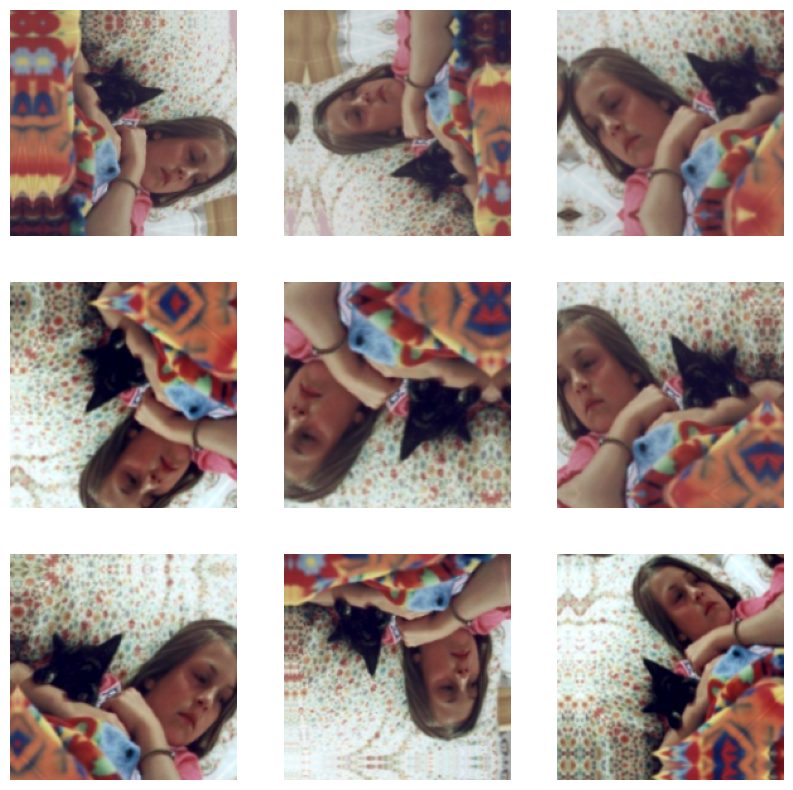

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = AUGMENTATION(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (AUGMENTATION(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Build a model

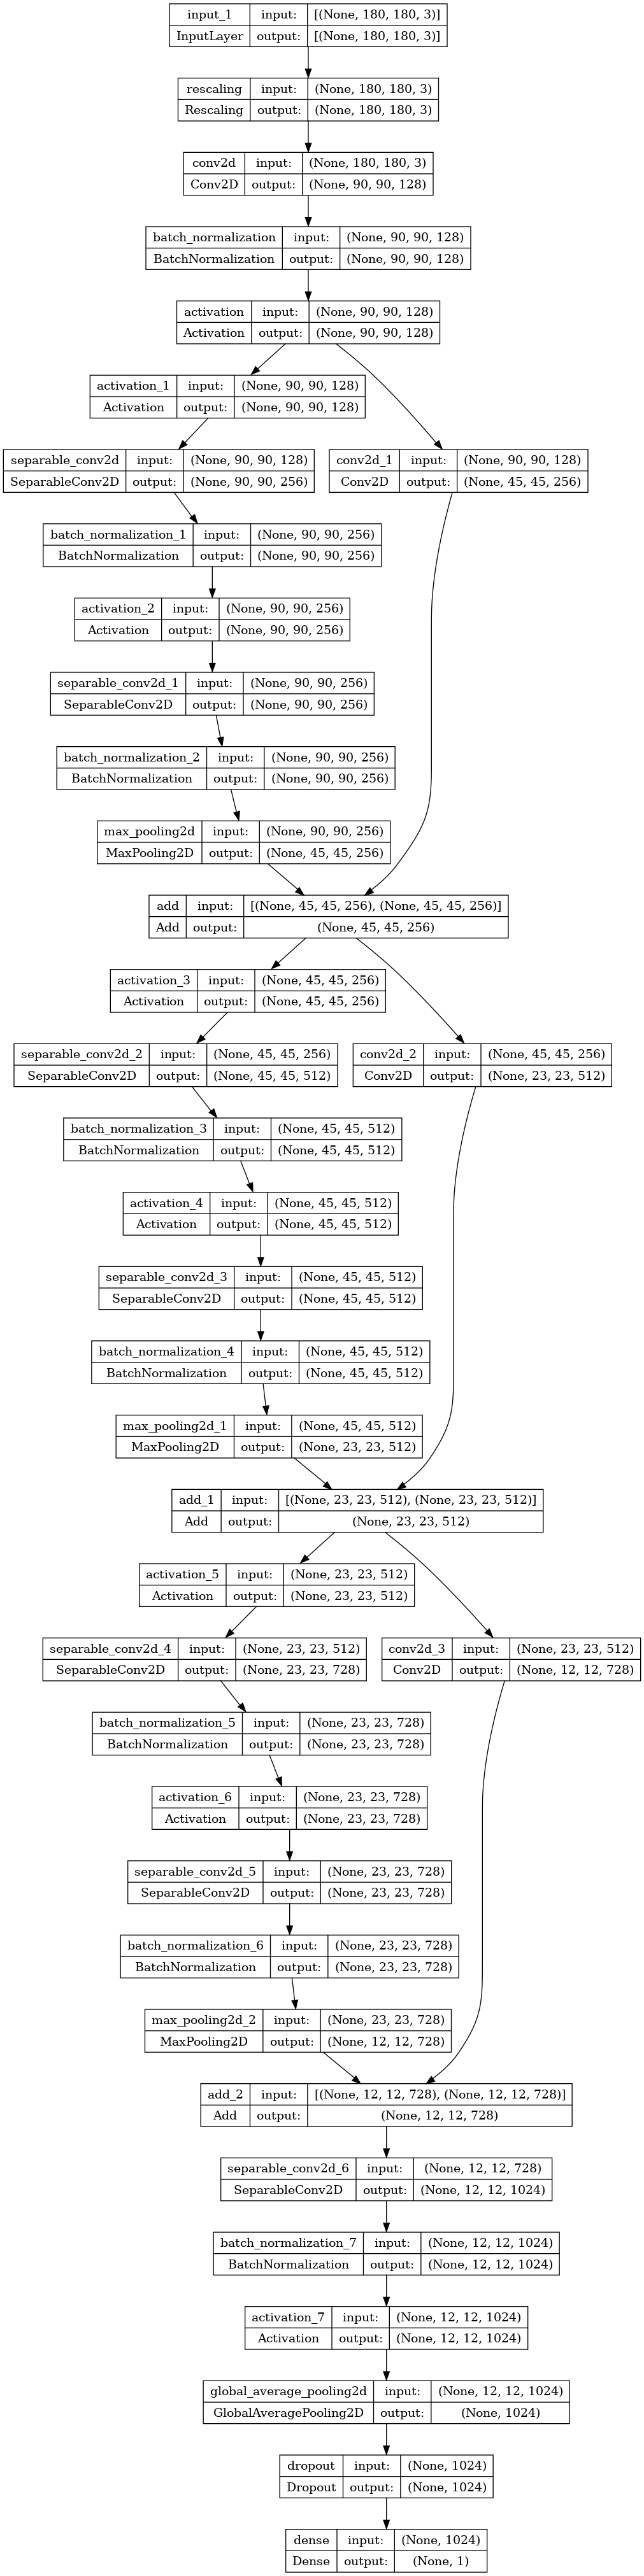

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Train the model

In [13]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
29/29 [==============================] - 83s 1s/step - loss: -5.6997 - accuracy: 0.2851 - val_loss: -0.5163 - val_accuracy: 0.1667
Epoch 2/25
29/29 [==============================] - 60s 2s/step - loss: -17.1221 - accuracy: 0.2632 - val_loss: -1.7487 - val_accuracy: 0.1667
Epoch 3/25
29/29 [==============================] - 60s 2s/step - loss: -30.0254 - accuracy: 0.2646 - val_loss: -2.4182 - val_accuracy: 0.1667
Epoch 4/25
29/29 [==============================] - 60s 2s/step - loss: -40.7703 - accuracy: 0.2646 - val_loss: -5.7113 - val_accuracy: 0.1667
Epoch 5/25
29/29 [==============================] - 60s 2s/step - loss: -58.1319 - accuracy: 0.2646 - val_loss: -8.2101 - val_accuracy: 0.1667
Epoch 6/25
29/29 [==============================] - 61s 2s/step - loss: -73.7439 - accuracy: 0.2646 - val_loss: -6.0389 - val_accuracy: 0.1667
Epoch 7/25
29/29 [==============================] - 60s 2s/step - loss: -100.9268 - accuracy: 0.2646 - val_loss: -11.3279 - val_accuracy: 0.166

In [14]:
img = keras.utils.load_img(
    "/kaggle/input/animal-picture-set-cat-penguin/animals_small_cat_penguin/animals_small_cat_penguin/cats/21_cat.png", target_size=image_size
)

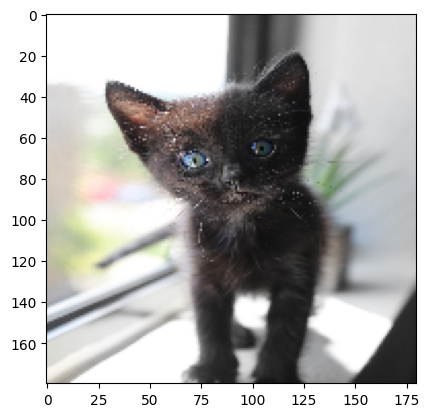

In [15]:
plt.imshow(img)

In [16]:
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

In [17]:
predictions = model.predict(img_array)
predictions

1/1 [==============================] - 1s 674ms/step


array([[1.]], dtype=float32)

In [18]:
score = float(predictions[0])
score

1.0

In [19]:
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% penguim.")

This image is 0.00% cat and 100.00% penguim.
